In [1]:
import torch
from torchvision.utils import make_grid
from torchvision.io import read_image
# from torchvision import models, transforms
# import sys
# import os
from PIL import Image
import torch
# import torch.functional as F
import numpy as np
# clear_output()
# import glob
from utils import *
from datetime import date
from torch.optim import lr_scheduler
import torchvision
from constants import mean, std
from PapilledemaLoader import PapilledemaDataset, PapilSeverityDataset, OHTSDataset, OHTSSeverityDataset
import torch.nn as nn
import torch.optim as optim

/home/hongn/miniconda3/envs/xai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = '/mnt/c/Users/PCM/Dropbox/chla_fundus_croped/severity'
datalne = {'train':10000, 'val':1000, 'test':1000}
image_datasets = {x: OHTSSeverityDataset(data_dir=data_dir, phase=x, datalen=datalne[x], mode="severity_comparison") for x in ['train', 'val', 'test']}
batch_size = {'train':16, 'val':16, 'test':1}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[x], shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = ['0','1']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)

cuda:0 ['0', '1']


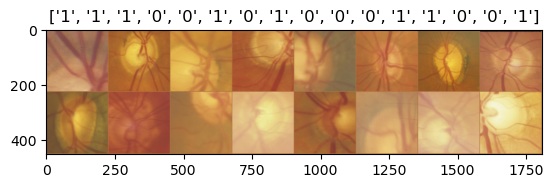

In [3]:
(inputs, _), classes, zzz = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes], mean=mean, std=std)

In [5]:
smodel = SeverityModel(path2pretrained='./pretrained/OHTS-contrastive50-2024-03-12.pt').to(device)
momentum = 0
lr = 0.01
optimizer_ft = optim.SGD([{'params': smodel.bestsimese50simclr.cnn1.conv1.parameters()},
                        {'params': smodel.bestsimese50simclr.cnn1.layer1.parameters()},
                        {'params': smodel.bestsimese50simclr.cnn1.layer2.parameters()},
                        {'params': smodel.bestsimese50simclr.cnn1.layer3.parameters()},
                        {'params': smodel.bestsimese50simclr.cnn1.layer4.parameters()},
                        {'params': smodel.bestsimese50simclr.cnn1.fc.parameters()},
                        {'params': smodel.bestsimese50simclr.cnn1.fc2.parameters(), 'lr':lr*10}], lr=lr, momentum=momentum)
loss_fn = PreferenceComparisonLoss()
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5)

for param in smodel.bestsimese50simclr.cnn1.parameters():
    param.requires_grad = True
for param in smodel.bestsimese50simclr.cnn1.fc2.parameters():
    param.requires_grad = True

load simclr resnet


In [6]:
valaccmax = 0
trainlosslist = []
trainacclist  = []

In [7]:
# valaccmax = 0
# trainlosslist = []
# trainacclist  = []
# torch.set_grad_enabled(True)
for e in range(10):
    training_acc = 0
    val_acc = 0
    training_loss_test = 0.0
    curr_loss = 100
    for inputs, labels, _ in dataloaders['train']:
        smodel.train()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer_ft.zero_grad()
        ref = [image_datasets['train'].get_ref_images() for i in range(len(inputA))]
        ref = torch.stack(ref).to(device)
        output1, output2, refimg = smodel(inputA, inputB, ref)
        loss = loss_fn(output1, output2, labels, refimg)
        loss.backward()
        optimizer_ft.step()
        training_loss_test += loss.item()


    if(training_loss_test < curr_loss):
        curr_loss = training_loss_test
        today = date.today()
        torch.save(smodel.state_dict(), f'./pretrained/OHTS-smodel50-wofreeze-{today}.pt')

    scheduler.step()

    print(f"E{e} With LR {optimizer_ft.param_groups[0]['lr']}", "traning loss: ", training_loss_test / dataset_sizes['train'])

E0 With LR 0.01 traning loss:  -0.03168625345826149
E1 With LR 0.01 traning loss:  -0.031538538970053195
E2 With LR 0.01 traning loss:  -0.03248721338063478
E3 With LR 0.01 traning loss:  -0.031744995565712454
E4 With LR 0.01 traning loss:  -0.03278883656039834
E5 With LR 0.01 traning loss:  -0.03169030616953969
E6 With LR 0.01 traning loss:  -0.031767472930252554
E7 With LR 0.01 traning loss:  -0.032165886237472296
E8 With LR 0.01 traning loss:  -0.03264166277423501
E9 With LR 0.005 traning loss:  -0.03135164844095707
